```{post} 2023-10-26

```


# Optimizing Scikit-Learn with Array API and Numba

In this tutorial, we will walk through increasing the performance of your scikit-learn code using `egglog` and [`numba`](https://numba.readthedocs.io/en/stable/user/5minguide.html).

One of the goals of `egglog` is to be used by other scientific computing libraries to create flexible APIs,
which conform to existing user expectations but allow a greater flexability in how they perform execution.

To work towards that we goal, we have built an prototype of a [Array API standard](https://data-apis.org/array-api/2022.12/index.html) conformant API
that can be used with [Scikit-Learn's experimental Array API support](https://scikit-learn.org/stable/modules/array_api.html),
to optimize it using Numba.

## Normal execution

We can create a test data set and use `LDA` to create a classification. Then we can run it on the dataset, to
return the estimated classification for out test data:


In [1]:
from sklearn import config_context
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def run_lda(x, y):
    with config_context(array_api_dispatch=True):
        lda = LinearDiscriminantAnalysis()
        return lda.fit(x, y).transform(x)


X_np, y_np = make_classification(random_state=0, n_samples=1000000)
run_lda(X_np, y_np)

array([[ 0.64233002],
       [ 0.63661245],
       [-1.603293  ],
       ...,
       [-1.1506433 ],
       [ 0.71687176],
       [-1.51119579]])

## Building our inputs

Now, we can try executing it with `egglog` instead. In this mode, we aren't actually passing in any particular
NDArray, but instead just using variables to represent the X and Y values.

These are defined in the [`egglog.exp.array_api` module](https://github.com/egraphs-good/egglog-python/blob/main/python/egglog/exp/array_api.py), as typed values:

```python
@array_api_module.class_
class NDArray(Expr):
    @array_api_module.method(cost=200)
    @classmethod
    def var(cls, name: StringLike) -> NDArray: ...

    @property
    def shape(self) -> TupleInt: ...

    ...

@array_api_module.function(mutates_first_arg=True)
def assume_shape(x: NDArray, shape: TupleInt) -> None: ...
```

We can use these functon to provides some metadata about the arguments as well:


In [2]:
from copy import copy

from egglog.exp.array_api import (
    NDArray,
    assume_dtype,
    assume_shape,
    assume_isfinite,
    assume_value_one_of,
)

X_arr = NDArray.var("X")
X_orig = copy(X_arr)

assume_dtype(X_arr, X_np.dtype)
assume_shape(X_arr, X_np.shape)
assume_isfinite(X_arr)

y_arr = NDArray.var("y")
y_orig = copy(y_arr)

assume_dtype(y_arr, y_np.dtype)
assume_shape(y_arr, y_np.shape)
assume_value_one_of(y_arr, (0, 1))

While most of the execution can be deferred, every time sklearn triggers Python control flow (`if`, `for`, etc), we
need to execute eagerly and be able to give a definate value. For example, scikit-learn checks to makes sure that the
number of samples we pass in is greater than the number of unique classes:

```python
class LinearDiscriminantAnalysis(...):
    ...
    def fit(self, X, y):
        ...
        self.classes_ = unique_labels(y)
        n_samples, _ = X.shape
        n_classes = self.classes_.shape[0]

        if n_samples == n_classes:
            raise ValueError(
                "The number of samples must be more than the number of classes."
            )
        ...
```

Without the assumptions above, we wouldn't know if the conditional is true or false. So we provide just enough information
for sklearn to finish executing and give us a result.

## Getting a result

We can now run our lda function with our inputs, which have the constraints about them saved, and see the graph which
will show all of the intermerdiate results we had to compute to get our answer:


In [3]:
from egglog import EGraph
from egglog.exp.array_api import array_api_module

with EGraph([array_api_module]) as egraph:
    X_r2 = run_lda(X_arr, y_arr)
    egraph.display(n_inline_leaves=3, split_primitive_outputs=True)
X_r2

_NDArray_1 = NDArray.var("X")
assume_dtype(_NDArray_1, DType.float64)
assume_shape(_NDArray_1, TupleInt(Int(1000000)) + TupleInt(Int(20)))
assume_isfinite(_NDArray_1)
_NDArray_2 = NDArray.var("y")
assume_dtype(_NDArray_2, DType.int64)
assume_shape(_NDArray_2, TupleInt(Int(1000000)))
assume_value_one_of(_NDArray_2, TupleValue(Value.int(Int(0))) + TupleValue(Value.int(Int(1))))
_NDArray_3 = asarray(reshape(asarray(_NDArray_2), TupleInt(Int(-1))))
_NDArray_4 = astype(unique_counts(_NDArray_3)[Int(1)], asarray(_NDArray_1).dtype) / NDArray.scalar(Value.float(Float(1000000.0)))
_NDArray_5 = zeros(
    TupleInt(unique_inverse(_NDArray_3)[Int(0)].shape[Int(0)]) + TupleInt(asarray(_NDArray_1).shape[Int(1)]),
    OptionalDType.some(asarray(_NDArray_1).dtype),
    OptionalDevice.some(asarray(_NDArray_1).device),
)
_MultiAxisIndexKey_1 = MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice()))
_IndexKey_1 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(0))) + _MultiAxisIndexKey_1)
_OptionalIntOrTuple_1 = OptionalIntOrTuple.some(IntOrTuple.int(Int(0)))
_NDArray_5[_IndexKey_1] = mean(asarray(_NDArray_1)[ndarray_index(unique_inverse(_NDArray_3)[Int(1)] == NDArray.scalar(Value.int(Int(0))))], _OptionalIntOrTuple_1)
_IndexKey_2 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(1))) + _MultiAxisIndexKey_1)
_NDArray_5[_IndexKey_2] = mean(asarray(_NDArray_1)[ndarray_index(unique_inverse(_NDArray_3)[Int(1)] == NDArray.scalar(Value.int(Int(1))))], _OptionalIntOrTuple_1)
_NDArray_6 = unique_values(concat(TupleNDArray(unique_values(asarray(_NDArray_3)))))
_NDArray_7 = concat(
    TupleNDArray(asarray(_NDArray_1)[ndarray_index(_NDArray_3 == _NDArray_6[IndexKey.int(Int(0))])] - _NDArray_5[_IndexKey_1])
    + TupleNDArray(asarray(_NDArray_1)[ndarray_index(_NDArray_3 == _NDArray_6[IndexKey.int(Int(1))])] - _NDArray_5[_IndexKey_2]),
    OptionalInt.some(Int(0)),
)
_NDArray_8 = std(_NDArray_7, _OptionalIntOrTuple_1)
_NDArray_8[ndarray_index(std(_NDArray_7, _OptionalIntOrTuple_1) == NDArray.scalar(Value.int(Int(0))))] = NDArray.scalar(Value.float(Float(1.0)))
_TupleNDArray_1 = svd(
    sqrt(asarray(NDArray.scalar(Value.float(Float(1.0) / Float.from_int(asarray(_NDArray_1).shape[Int(0)] - _NDArray_6.shape[Int(0)]))))) * (_NDArray_7 / _NDArray_8), FALSE
)
_Slice_1 = Slice(OptionalInt.none, OptionalInt.some(sum(astype(_TupleNDArray_1[Int(1)] > NDArray.scalar(Value.float(Float(0.0001))), DType.int32)).to_value().to_int))
_NDArray_9 = (_TupleNDArray_1[Int(2)][IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(_Slice_1)) + _MultiAxisIndexKey_1)] / _NDArray_8).T / _TupleNDArray_1[
    Int(1)
][IndexKey.slice(_Slice_1)]
_TupleNDArray_2 = svd(
    (
        sqrt(
            (NDArray.scalar(Value.int(asarray(_NDArray_1).shape[Int(0)])) * _NDArray_4)
            * NDArray.scalar(Value.float(Float(1.0) / Float.from_int(_NDArray_6.shape[Int(0)] - Int(1))))
        )
        * (_NDArray_5 - (_NDArray_4 @ _NDArray_5)).T
    ).T
    @ _NDArray_9,
    FALSE,
)
(
    (asarray(_NDArray_1) - (_NDArray_4 @ _NDArray_5))
    @ (
        _NDArray_9
        @ _TupleNDArray_2[Int(2)].T[
            IndexKey.multi_axis(
                _MultiAxisIndexKey_1
                + MultiAxisIndexKey(
                    MultiAxisIndexKeyItem.slice(
                        Slice(
                            OptionalInt.none,
                            OptionalInt.some(
                                sum(astype(_TupleNDArray_2[Int(1)] > (NDArray.scalar(Value.float(Float(0.0001))) * _TupleNDArray_2[Int(1)][IndexKey.int(Int(0))]), DType.int32))
                                .to_value()
                                .to_int
                            ),
                        )
                    )
                )
            )
        ]
    )
)[IndexKey.multi_axis(_MultiAxisIndexKey_1 + MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice(OptionalInt.none, OptionalInt.some(_NDArray_6.shape[Int(0)] - Int(1))))))]

We now have extracted out a program which is semantically equivalent to the original call! One thing you might notice
is that the expression has more types than customary NumPy code. Every object is lifted into a strongly typed `egglog`
class. This is so that when we run optimizations, we know the types of all the objects. It still is compatible with
normal Python objects, but they are [converted](type-promotion) when they are passed as argument.

## Optimizing our result

Now that we have the an expression, we can run our rewrite rules to "optimize" it, extracting out the lowest cost
(smallest) expression afterword:


In [4]:
egraph = EGraph([array_api_module])
egraph.register(X_r2)
egraph.run(10000)
X_r2_optimized = egraph.extract(X_r2)
X_r2_optimized

_NDArray_1 = NDArray.var("X")
assume_dtype(_NDArray_1, DType.float64)
assume_shape(_NDArray_1, TupleInt(Int(1000000)) + TupleInt(Int(20)))
assume_isfinite(_NDArray_1)
_NDArray_2 = NDArray.var("y")
assume_dtype(_NDArray_2, DType.int64)
assume_shape(_NDArray_2, TupleInt(Int(1000000)))
assume_value_one_of(_NDArray_2, TupleValue(Value.int(Int(0))) + TupleValue(Value.int(Int(1))))
_NDArray_3 = astype(unique_counts(_NDArray_2)[Int(1)], DType.float64) / NDArray.scalar(Value.float(Float(1000000.0)))
_NDArray_4 = zeros(TupleInt(Int(2)) + TupleInt(Int(20)), OptionalDType.some(DType.float64), OptionalDevice.some(_NDArray_1.device))
_MultiAxisIndexKey_1 = MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice()))
_IndexKey_1 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(0))) + _MultiAxisIndexKey_1)
_OptionalIntOrTuple_1 = OptionalIntOrTuple.some(IntOrTuple.int(Int(0)))
_NDArray_4[_IndexKey_1] = mean(_NDArray_1[ndarray_index(unique_inverse(_NDArray_2)[Int(1)] == NDArray.scalar(Value.int(Int(0))))], _OptionalIntOrTuple_1)
_IndexKey_2 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(1))) + _MultiAxisIndexKey_1)
_NDArray_4[_IndexKey_2] = mean(_NDArray_1[ndarray_index(unique_inverse(_NDArray_2)[Int(1)] == NDArray.scalar(Value.int(Int(1))))], _OptionalIntOrTuple_1)
_NDArray_5 = concat(
    TupleNDArray(_NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(0))))] - _NDArray_4[_IndexKey_1])
    + TupleNDArray(_NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(1))))] - _NDArray_4[_IndexKey_2]),
    OptionalInt.some(Int(0)),
)
_NDArray_6 = std(_NDArray_5, _OptionalIntOrTuple_1)
_NDArray_6[ndarray_index(std(_NDArray_5, _OptionalIntOrTuple_1) == NDArray.scalar(Value.int(Int(0))))] = NDArray.scalar(Value.float(Float(1.0)))
_TupleNDArray_1 = svd(sqrt(NDArray.scalar(Value.float(Float(1.0) / Float.from_int(Int(999998))))) * (_NDArray_5 / _NDArray_6), FALSE)
_Slice_1 = Slice(OptionalInt.none, OptionalInt.some(sum(astype(_TupleNDArray_1[Int(1)] > NDArray.scalar(Value.float(Float(0.0001))), DType.int32)).to_value().to_int))
_NDArray_7 = (_TupleNDArray_1[Int(2)][IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(_Slice_1)) + _MultiAxisIndexKey_1)] / _NDArray_6).T / _TupleNDArray_1[
    Int(1)
][IndexKey.slice(_Slice_1)]
_TupleNDArray_2 = svd(
    (sqrt((NDArray.scalar(Value.int(Int(1000000))) * _NDArray_3) * NDArray.scalar(Value.float(Float(1.0)))) * (_NDArray_4 - (_NDArray_3 @ _NDArray_4)).T).T @ _NDArray_7, FALSE
)
(
    (_NDArray_1 - (_NDArray_3 @ _NDArray_4))
    @ (
        _NDArray_7
        @ _TupleNDArray_2[Int(2)].T[
            IndexKey.multi_axis(
                _MultiAxisIndexKey_1
                + MultiAxisIndexKey(
                    MultiAxisIndexKeyItem.slice(
                        Slice(
                            OptionalInt.none,
                            OptionalInt.some(
                                sum(astype(_TupleNDArray_2[Int(1)] > (NDArray.scalar(Value.float(Float(0.0001))) * _TupleNDArray_2[Int(1)][IndexKey.int(Int(0))]), DType.int32))
                                .to_value()
                                .to_int
                            ),
                        )
                    )
                )
            )
        ]
    )
)[IndexKey.multi_axis(_MultiAxisIndexKey_1 + MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice(OptionalInt.none, OptionalInt.some(Int(1))))))]

We see that for example expressions that referenced the shape of our input arrays have been resolved to their
values.

We can also take a look at the e-graph itself, even though it's quite large, where we can see that equivalent
expressions show up in the same group, or "e-class":


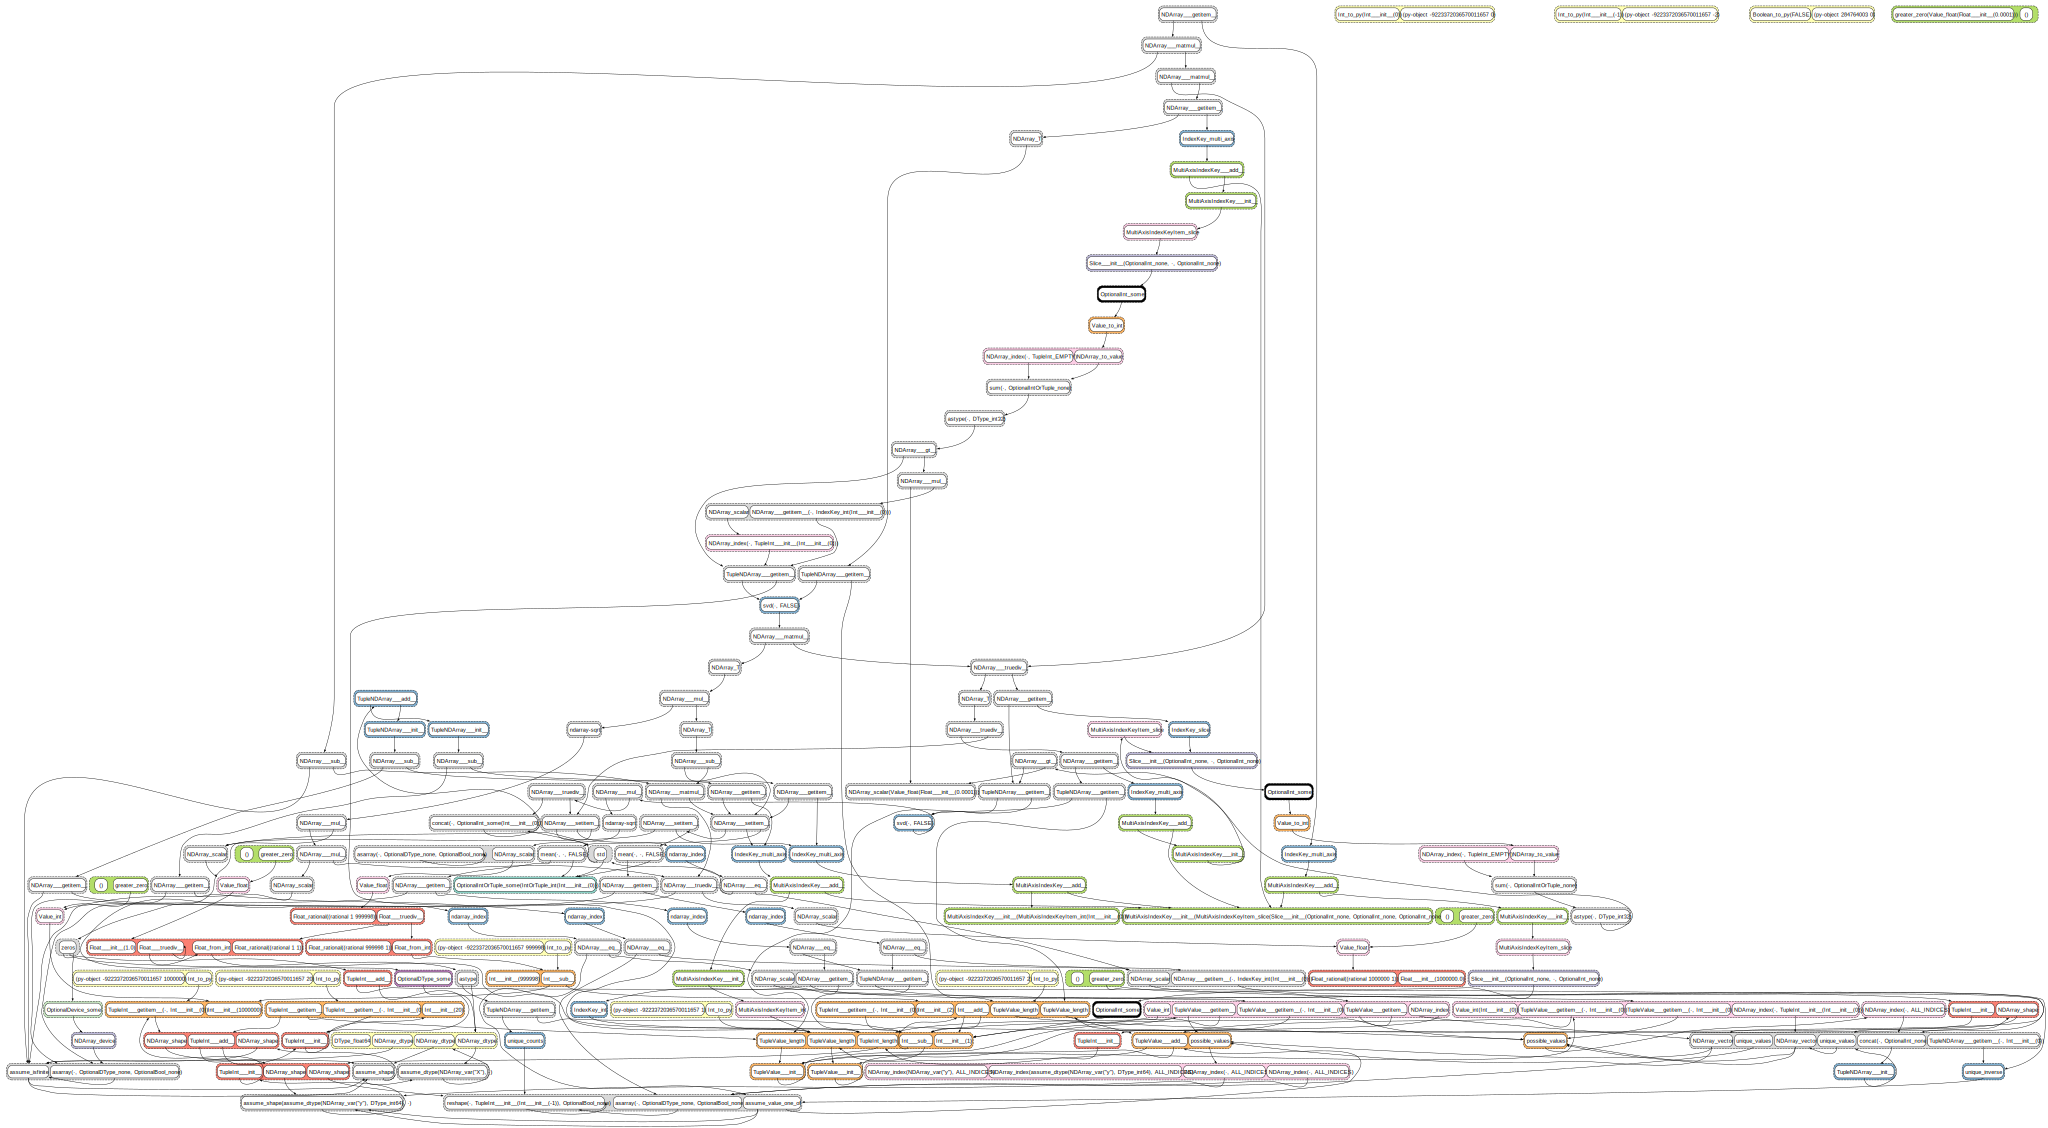

In [5]:
egraph.display(n_inline_leaves=3, split_primitive_outputs=True)

## Translating for Numba

We are getting closer to a form we could translate back to Numba, but we have to make a few changes. Numba doesn't
support the `axis` keyword for `mean` or `std`, but it does support it for `sum`, so we have to translate all forms
from one to the other, with a rule like this (defined in [`egglog.exp.array_api_numba`](https://github.com/egraphs-good/egglog-python/blob/main/python/egglog/exp/array_api_numba.py)):

```python
axis = OptionalIntOrTuple.some(IntOrTuple.int(i))
rewrite(std(x, axis)).to(sqrt(mean(square(abs(x - mean(x, axis, keepdims=TRUE))), axis)))
```

We can run those additional rewrites now to get a new extracted version


In [6]:
from egglog.exp.array_api_numba import array_api_numba_module

egraph = EGraph([array_api_numba_module])
egraph.register(X_r2_optimized)
egraph.run(10000)
X_r2_numba = egraph.extract(X_r2_optimized)
X_r2_numba

_NDArray_1 = NDArray.var("X")
assume_dtype(_NDArray_1, DType.float64)
assume_shape(_NDArray_1, TupleInt(Int(1000000)) + TupleInt(Int(20)))
assume_isfinite(_NDArray_1)
_NDArray_2 = NDArray.var("y")
assume_dtype(_NDArray_2, DType.int64)
assume_shape(_NDArray_2, TupleInt(Int(1000000)))
assume_value_one_of(_NDArray_2, TupleValue(Value.int(Int(0))) + TupleValue(Value.int(Int(1))))
_NDArray_3 = astype(
    NDArray.vector(TupleValue(sum(_NDArray_2 == NDArray.scalar(Value.int(Int(0)))).to_value()) + TupleValue(sum(_NDArray_2 == NDArray.scalar(Value.int(Int(1)))).to_value())),
    DType.float64,
) / NDArray.scalar(Value.float(Float(1000000.0)))
_NDArray_4 = zeros(TupleInt(Int(2)) + TupleInt(Int(20)), OptionalDType.some(DType.float64), OptionalDevice.some(_NDArray_1.device))
_MultiAxisIndexKey_1 = MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice()))
_IndexKey_1 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(0))) + _MultiAxisIndexKey_1)
_NDArray_5 = _NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(0))))]
_OptionalIntOrTuple_1 = OptionalIntOrTuple.some(IntOrTuple.int(Int(0)))
_NDArray_4[_IndexKey_1] = sum(_NDArray_5, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_5.shape[Int(0)]))
_IndexKey_2 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(1))) + _MultiAxisIndexKey_1)
_NDArray_6 = _NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(1))))]
_NDArray_4[_IndexKey_2] = sum(_NDArray_6, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_6.shape[Int(0)]))
_NDArray_7 = concat(TupleNDArray(_NDArray_5 - _NDArray_4[_IndexKey_1]) + TupleNDArray(_NDArray_6 - _NDArray_4[_IndexKey_2]), OptionalInt.some(Int(0)))
_NDArray_8 = square(_NDArray_7 - expand_dims(sum(_NDArray_7, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_7.shape[Int(0)]))))
_NDArray_9 = sqrt(sum(_NDArray_8, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_8.shape[Int(0)])))
_NDArray_10 = copy(_NDArray_9)
_NDArray_10[ndarray_index(_NDArray_9 == NDArray.scalar(Value.int(Int(0))))] = NDArray.scalar(Value.float(Float(1.0)))
_TupleNDArray_1 = svd(sqrt(NDArray.scalar(Value.float(Float(1.0) / Float.from_int(Int(999998))))) * (_NDArray_7 / _NDArray_10), FALSE)
_Slice_1 = Slice(OptionalInt.none, OptionalInt.some(sum(astype(_TupleNDArray_1[Int(1)] > NDArray.scalar(Value.float(Float(0.0001))), DType.int32)).to_value().to_int))
_NDArray_11 = (_TupleNDArray_1[Int(2)][IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(_Slice_1)) + _MultiAxisIndexKey_1)] / _NDArray_10).T / _TupleNDArray_1[
    Int(1)
][IndexKey.slice(_Slice_1)]
_TupleNDArray_2 = svd(
    (sqrt((NDArray.scalar(Value.int(Int(1000000))) * _NDArray_3) * NDArray.scalar(Value.float(Float(1.0)))) * (_NDArray_4 - (_NDArray_3 @ _NDArray_4)).T).T @ _NDArray_11, FALSE
)
(
    (_NDArray_1 - (_NDArray_3 @ _NDArray_4))
    @ (
        _NDArray_11
        @ _TupleNDArray_2[Int(2)].T[
            IndexKey.multi_axis(
                _MultiAxisIndexKey_1
                + MultiAxisIndexKey(
                    MultiAxisIndexKeyItem.slice(
                        Slice(
                            OptionalInt.none,
                            OptionalInt.some(
                                sum(astype(_TupleNDArray_2[Int(1)] > (NDArray.scalar(Value.float(Float(0.0001))) * _TupleNDArray_2[Int(1)][IndexKey.int(Int(0))]), DType.int32))
                                .to_value()
                                .to_int
                            ),
                        )
                    )
                )
            )
        ]
    )
)[IndexKey.multi_axis(_MultiAxisIndexKey_1 + MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice(OptionalInt.none, OptionalInt.some(Int(1))))))]

## Compiling back to Python source

Now we finally have a version that we could run with Numba! However, this isn't in NumPy code. What Numba needs
is a function that uses `numpy`, not our typed dialect.

So we use another module that provides a translation of all our methods into Python strings. The rules in it look like this:

```python
# the sqrt of an array should use the `np.sqrt` function and be assigned to its own variable, so it can be reused
rewrite(ndarray_program(sqrt(x))).to((Program("np.sqrt(") + ndarray_program(x) + ")").assign())

# To compile a setitem call, we first compile the source, assign it to a variable, then add an assignment statement
mod_x = copy(x)
mod_x[idx] = y
assigned_x = ndarray_program(x).assign()
yield rewrite(ndarray_program(mod_x)).to(
    assigned_x.statement(assigned_x + "[" + index_key_program(idx) + "] = " + ndarray_program(y))
)
```

We pull in all those rewrite rules from the [`egglog.exp.array_api_program_gen` module](https://github.com/egraphs-good/egglog-python/blob/main/python/egglog/exp/array_api_program_gen.py).
They depend on another module, [`egglog.exp.program_gen` module](https://github.com/egraphs-good/egglog-python/blob/main/python/egglog/exp/program_gen.py), which provides generic translations
from expressions and statements into strings.

We can run these rules to get out a Python function object:


In [7]:
from egglog.exp.array_api_program_gen import (
    ndarray_function_two,
    array_api_module_string,
)

egraph = EGraph([array_api_module_string])
fn_program = ndarray_function_two(X_r2_numba, X_orig, y_orig)
egraph.register(fn_program)
egraph.run(10000)
fn = egraph.load_object(egraph.extract(fn_program.py_object))
import inspect

print(inspect.getsource(fn))

def __fn(X, y):
    assert X.dtype == np.dtype(np.float64)
    assert X.shape == (1000000, 20,)
    assert np.all(np.isfinite(X))
    assert y.dtype == np.dtype(np.int64)
    assert y.shape == (1000000,)
    assert set(np.unique(y)) == set((0, 1,))
    _0 = y == np.array(0)
    _1 = np.sum(_0)
    _2 = y == np.array(1)
    _3 = np.sum(_2)
    _4 = np.array((_1, _3,)).astype(np.dtype(np.float64))
    _5 = _4 / np.array(1000000.0)
    _6 = np.zeros((2, 20,), dtype=np.dtype(np.float64))
    _7 = np.sum(X[_0], axis=0)
    _8 = _7 / np.array(X[_0].shape[0])
    _6[0, :] = _8
    _9 = np.sum(X[_2], axis=0)
    _10 = _9 / np.array(X[_2].shape[0])
    _6[1, :] = _10
    _11 = _5 @ _6
    _12 = X - _11
    _13 = np.sqrt(np.array((1.0 / 999998)))
    _14 = X[_0] - _6[0, :]
    _15 = X[_2] - _6[1, :]
    _16 = np.concatenate((_14, _15,), axis=0)
    _17 = np.sum(_16, axis=0)
    _18 = _17 / np.array(_16.shape[0])
    _19 = np.expand_dims(_18, 0)
    _20 = _16 - _19
    _21 = np.square(_20)
    _2

We can verify that the function gives the same result:


In [8]:
import numpy as np

assert np.allclose(run_lda(X_np, y_np), fn(X_np, y_np))

Although it isn't the prettiest, we can see that it has only emitted each expression once, for common subexpression
elimination, and preserves the "imperative" aspects of setitem.

## Compiling to Numba

Now we finally have a function we can run with numba:


In [9]:
import numba
import os

fn_numba = numba.njit(fastmath=True)(fn)
assert np.allclose(run_lda(X_np, y_np), fn_numba(X_np, y_np))

/var/folders/xn/05ktz3056kqd9n8frgd6236h0000gn/T/egglog-9e61d62c-d17d-495b-b8db-f1eb3b38dcbb.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  _45 = _33 @ _40[2].T[:, :_44]


## Evaluating performance

Let's see if it actually made anything quicker! Let's run a number of trials for the original function, our
extracted version, and the optimized extracted version:


In [10]:
import timeit
import pandas as pd

stmts = {
    "original": "run_lda(X_np, y_np)",
    "extracted": "fn(X_np, y_np)",
    "extracted numba": "fn_numba(X_np, y_np)",
}
df = pd.DataFrame.from_dict(
    {name: timeit.repeat(stmt, globals=globals(), number=1, repeat=10) for name, stmt in stmts.items()}
)

df

,original,extracted,extracted numba
0,1.482975,1.609354,1.086486
1,1.498656,1.504704,1.145331
2,1.500998,1.557253,1.090356
3,1.519732,1.548800,1.122623
4,1.500420,1.501195,1.113089
5,1.587211,1.522518,1.176842
6,1.499479,1.526887,1.095296
7,1.639910,1.500859,1.086477
8,1.525145,1.559202,1.103662
9,1.535601,1.474299,1.074152


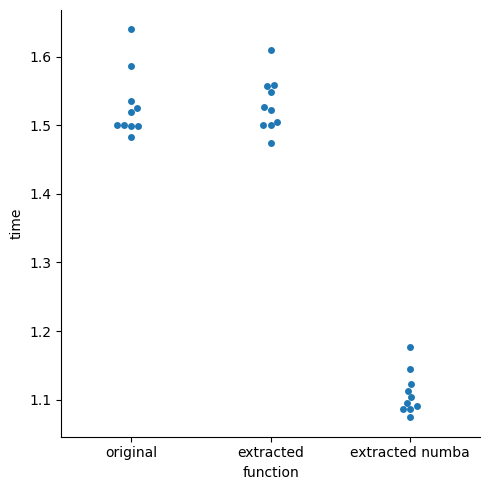

In [11]:
import seaborn as sns

df_melt = pd.melt(df, var_name="function", value_name="time")
_ = sns.catplot(data=df_melt, x="function", y="time", kind="swarm")

We see that the numba version is in fact faster, and the other two are about the same. It isn't significantly faster through,
so we might want to run a profiler on the original function to see where most of the time is spent:


In [12]:
%load_ext line_profiler

In [13]:
%lprun -f fn fn(X_np, y_np)

Timer unit: 1e-09 s

Total time: 1.41607 s
File: /var/folders/xn/05ktz3056kqd9n8frgd6236h0000gn/T/egglog-9e61d62c-d17d-495b-b8db-f1eb3b38dcbb.py
Function: __fn at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def __fn(X, y):
     2         1      13000.0  13000.0      0.0      assert X.dtype == np.dtype(np.float64)
     3         1       2000.0   2000.0      0.0      assert X.shape == (1000000, 20,)
     4         1   23813000.0    2e+07      1.7      assert np.all(np.isfinite(X))
     5         1      11000.0  11000.0      0.0      assert y.dtype == np.dtype(np.int64)
     6         1      14000.0  14000.0      0.0      assert y.shape == (1000000,)
     7         1   23226000.0    2e+07      1.6      assert set(np.unique(y)) == set((0, 1,))
     8         1     542000.0 542000.0      0.0      _0 = y == np.array(0)
     9         1     488000.0 488000.0      0.0      _1 = np.sum(_0)
    10         1     493000.0 

We see that most of the time is spent in the SVD funciton, which [wouldn't be improved much by numba](https://github.com/numba/numba/issues/2423)
since it is will call out to LAPACK, just like NumPy. The only savings would come from the other parts of the progarm,
which can be inlined into

## Conclusion

To recap, in this tutorial we:

1. Tried using a normal scikit-learn LDA function on some test data.
2. Built up an abstract array and called it with that instead
3. Optimized it and translated it to work with Numba
4. Compiled it to a standalone Python funciton, which was optimized with Numba
5. Verified that this improved our performance with this test data.

The implementation of the Array API provided here is experimental, and not complete, but at least serves to show it is
possible to build an API like that with `egglog`.
